In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_path = "/content/drive/MyDrive/Baybayin.v14i.yolov5pytorch"


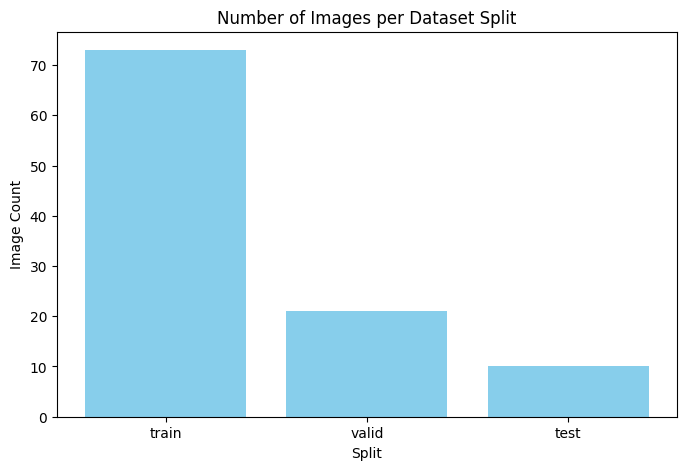

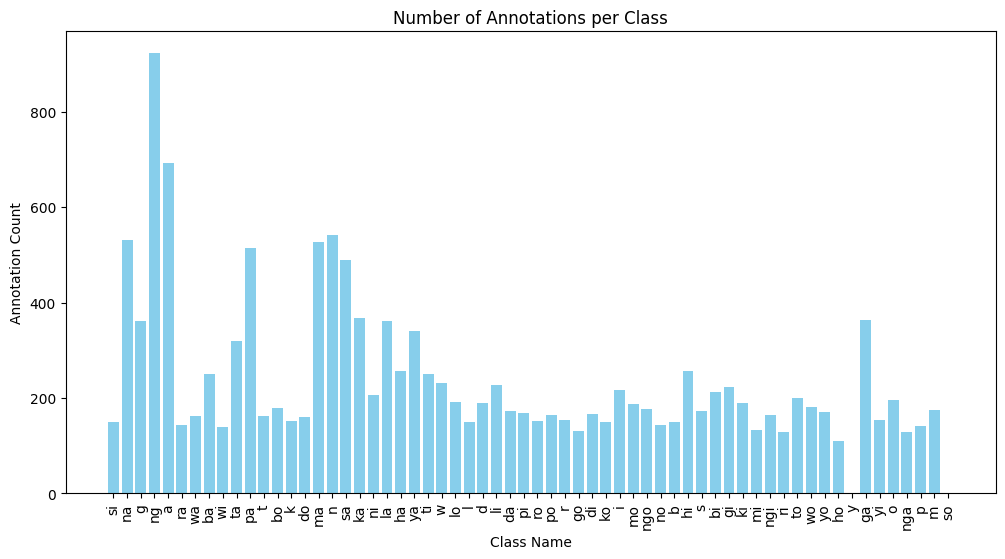

In [3]:
import os
import yaml
import matplotlib.pyplot as plt
from collections import Counter

base_path = '/content/drive/MyDrive/Baybayin.v14i.yolov5pytorch'
yaml_path = os.path.join(base_path, 'aug_data.yaml')
splits = ['train', 'valid', 'test']

image_counts = {}
for split in splits:
    img_dir = os.path.join(base_path, split, 'images')
    if os.path.exists(img_dir):
        count = len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        image_counts[split] = count
    else:
        image_counts[split] = 0

plt.figure(figsize=(8, 5))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.title('Number of Images per Dataset Split')
plt.ylabel('Image Count')
plt.xlabel('Split')
plt.show()

with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml['names']

class_counter = Counter()
for split in splits:
    label_dir = os.path.join(base_path, split, 'labels')
    if os.path.exists(label_dir):
        for file in os.listdir(label_dir):
            if file.endswith('.txt'):
                with open(os.path.join(label_dir, file), 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        class_id = int(line.strip().split()[0])
                        if class_id != 0 and class_id < len(class_names):
                            class_counter[class_names[class_id]] += 1

if class_counter:
    class_labels = list(class_counter.keys())
    counts = list(class_counter.values())

    plt.figure(figsize=(12, 6))
    plt.bar(class_labels, counts, color='skyblue')
    plt.title('Number of Annotations per Class')
    plt.ylabel('Annotation Count')
    plt.xlabel('Class Name')
    plt.xticks(rotation=90)
    plt.show()
else:
    print("No label files found.")


In [4]:
import os

image_dir = f"{dataset_path}/train/images"
label_dir = f"{dataset_path}/train/labels"

aug_image_dir = f"{dataset_path}/augmented/images"
aug_label_dir = f"{dataset_path}/augmented/labels"

os.makedirs(aug_image_dir, exist_ok=True)
os.makedirs(aug_label_dir, exist_ok=True)


In [5]:

!pip install -q ultralytics albumentations opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/s eta 0:00:00


In [12]:
import albumentations as A
import cv2

#Augmentations

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.MotionBlur(blur_limit=7, p=0.3),
    A.RandomBrightnessContrast(p=0.4),
    A.GaussNoise(p=0.3),
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(0.0, 0.05),
        rotate=(-15, 15),
        shear=(-10, 10),
        fit_output=True,
        p=0.5
    ),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


In [13]:
import os
import cv2
import albumentations as A
import shutil

# Clean labels to allow polygons (for bounding boxes)
fixed_count = 0
deleted_count = 0

for filename in os.listdir(label_dir):
    if not filename.endswith('.txt'):
        continue

    label_path = os.path.join(label_dir, filename)

    with open(label_path, 'r') as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        parts = line.strip().split()

        if len(parts) >= 5:
            new_lines.append(' '.join(parts))
        else:
            print(f"⚠️ {filename}: Skipping bad line: {line.strip()}")
            deleted_count += 1

    if new_lines:
        with open(label_path, 'w') as f:
            f.write('\n'.join(new_lines) + '\n')
    else:
        os.remove(label_path)
        print(f"Deleted empty label file: {filename}")

print(f"{deleted_count} bad label lines skipped.")

transform = A.Compose([
    A.HorizontalFlip(p=1.0),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for filename in os.listdir(image_dir):
    if not (filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg')):
        continue

    img_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))

    img = cv2.imread(img_path)

    if not os.path.exists(label_path) or img is None:
        print(f"{filename} No label or corrupted image")
        continue

with open(label_path, 'r') as f:
    labels = []
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 5:
            values = list(map(float, parts))
            cls, xc, yc, w, h = values[:5]

            x_min = xc - w / 2
            x_max = xc + w / 2
            y_min = yc - h / 2
            y_max = yc + h / 2

            if 0 <= x_min <= 1 and 0 <= x_max <= 1 and 0 <= y_min <= 1 and 0 <= y_max <= 1:
                labels.append(values)
            else:
                print(f"Invalid box skipped")


    if not labels:
        print(f"Skipped image, no valid labels.")

    classes = [int(x[0]) for x in labels]
    bboxes = [x[1:5] for x in labels]

    shutil.copy(img_path, os.path.join(aug_image_dir, filename))
    shutil.copy(label_path, os.path.join(aug_label_dir, filename.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')))

    try:
        augmented = transform(image=img, bboxes=bboxes, class_labels=classes)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_classes = augmented['class_labels']

        new_filename = f"aug_{filename}"
        cv2.imwrite(os.path.join(aug_image_dir, new_filename), aug_img)

        with open(os.path.join(aug_label_dir, new_filename.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')), 'w') as f:
            for cls, bbox in zip(aug_classes, aug_bboxes):
                f.write(f"{cls} {' '.join(map(str, bbox))}\n")

        print(f"Saved as: {new_filename}")

    except Exception as e:
        print(f"Augmentation failed for {filename}. Error: {e}")


0 bad label lines skipped.
Saved as: aug_ad_jpeg.rf.709c02f1f4df623042e18061ab48ddfc.jpg


In [14]:
aug_data_yaml = f"""
train: {dataset_path}/augmented/images
val: {dataset_path}/valid/images
test: {dataset_path}/test/images

nc: 63
names: ['-', 'a', 'b', 'ba', 'bi', 'bo', 'd', 'da', 'di', 'do', 'g', 'ga', 'gi', 'go', 'ha', 'hi', 'ho', 'i', 'k', 'ka', 'ki', 'ko', 'l', 'la', 'li', 'lo', 'm', 'ma', 'mi', 'mo', 'n', 'na', 'ng', 'nga', 'ngi', 'ngo', 'ni', 'no', 'o', 'p', 'pa', 'pi', 'po', 'r', 'ra', 'ri', 'ro', 's', 'sa', 'si', 'so', 't', 'ta', 'ti', 'to', 'w', 'wa', 'wi', 'wo', 'y', 'ya', 'yi', 'yo']
"""

with open(f"{dataset_path}/aug_data.yaml", "w") as f:
    f.write(aug_data_yaml)


In [49]:
import os

# Set your augmented dataset root
augmented_root = '/content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/augmented'

# Define image and label folders
image_dir = os.path.join(augmented_root, 'images')
label_dir = os.path.join(augmented_root, 'labels')

# Count image files
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
num_images = len(image_files)

# Count label files and bounding boxes
num_labels = 0
num_bboxes = 0

for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        num_labels += 1
        with open(os.path.join(label_dir, label_file), 'r') as f:
            lines = f.readlines()
            num_bboxes += len(lines)

print(f"Total augmented images: {num_images}")
print(f"Total augmented label files: {num_labels}")
print(f"Total bounding boxes across all labels: {num_bboxes}")


Total augmented images: 143
Total augmented label files: 143
Total bounding boxes across all labels: 17719


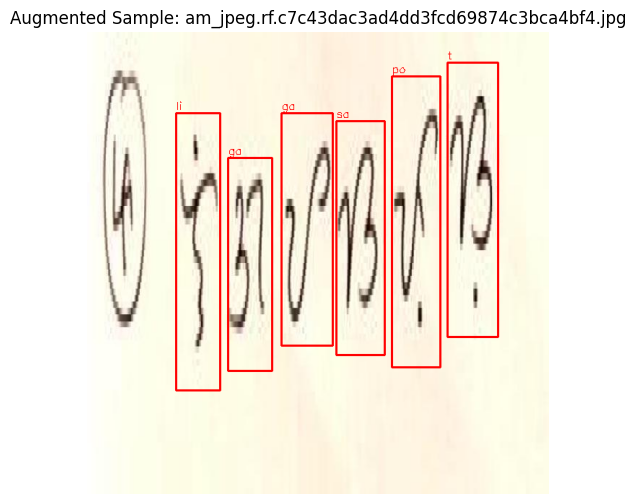

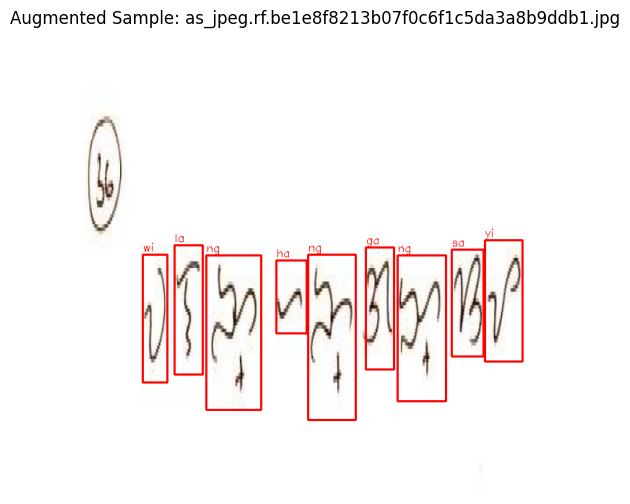

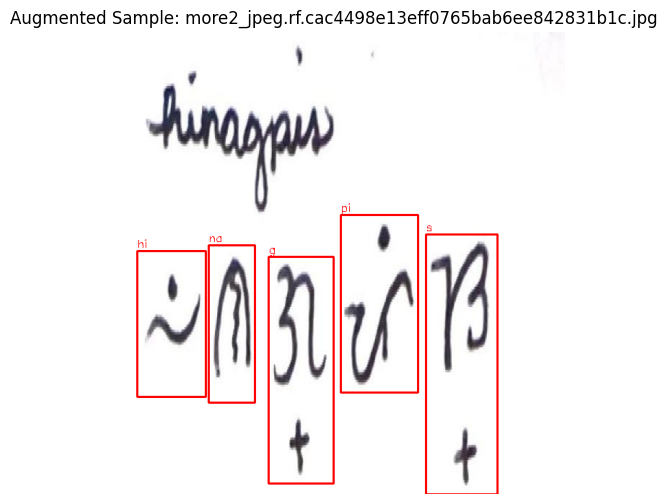

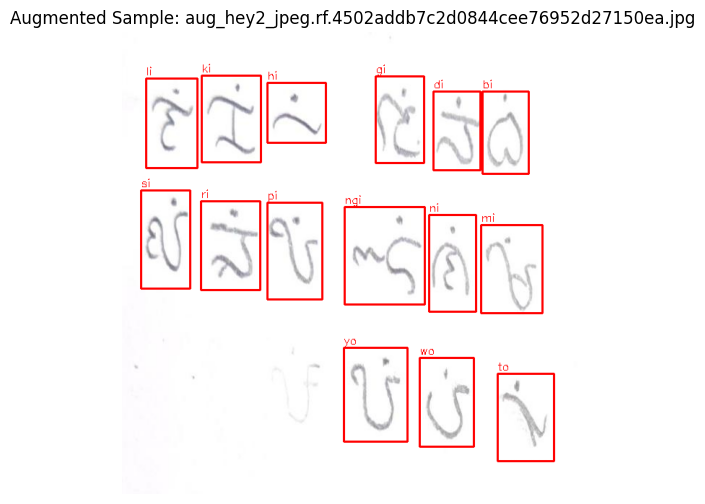

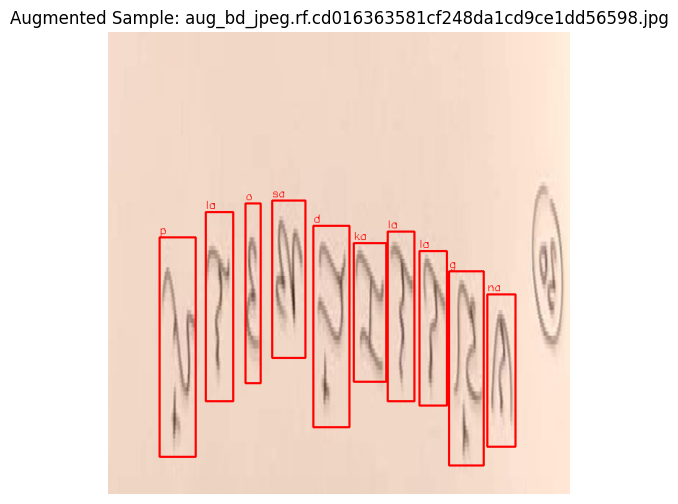

In [15]:
import os
import yaml
import random
import cv2
import matplotlib.pyplot as plt

base_path = '/content/drive/MyDrive/Baybayin.v14i.yolov5pytorch'

yaml_path = os.path.join(base_path, 'aug_data.yaml')
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml['names']

aug_image_dir = os.path.join(base_path, 'augmented', 'images')
aug_label_dir = os.path.join(base_path, 'augmented', 'labels')

aug_files = [f for f in os.listdir(aug_image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
sample_files = random.sample(aug_files, min(5, len(aug_files)))

for file in sample_files:
    img_path = os.path.join(aug_image_dir, file)
    label_path = os.path.join(aug_label_dir, file.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = list(map(float, line.strip().split()))
                if len(parts) >= 5 and int(parts[0]) != 0:
                    cls, xc, yc, bw, bh = parts[:5]
                    if int(cls) < len(class_names):
                        x1 = int((xc - bw / 2) * w)
                        y1 = int((yc - bh / 2) * h)
                        x2 = int((xc + bw / 2) * w)
                        y2 = int((yc + bh / 2) * h)
                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        cv2.putText(img, class_names[int(cls)], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Augmented Sample: {file}")
    plt.show()


In [16]:
from ultralytics import YOLO

model = YOLO("yolov8l.pt")

model.train(
    data=f"{dataset_path}/aug_data.yaml",
    epochs=100,
    imgsz=1024,
    batch=16,
    lr0=0.0010,
    device="cuda"
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 83.7M/83.7M [00:00<00:00, 291MB/s]


Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/aug_data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=1

100%|██████████| 755k/755k [00:00<00:00, 16.7MB/s]

Overriding model.yaml nc=80 with nc=63

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytic

  8                  -1  3   4461568  ultralytics.nn.modules.block.C2f             [512, 512, 3, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   4723712  ultralytics.nn.modules.block.C2f             [1024, 512, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  3   1247744  ultralytics.nn.modules.block.C2f             [768, 256, 3]                 
 16                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256,

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.3±0.1 ms, read: 39.9±20.9 MB/s, size: 48.4 KB)


train: Scanning /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/augmented/labels.cache... 143 images, 0 backgrounds, 37 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/augmented/images/-10_jpg.rf.5ff20847335186054ed7ca141ce8a157.jpg: ignoring corrupt image/label: Label class 63 exceeds dataset class count 63. Possible class labels are 0-62
train: /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/augmented/images/-26_jpg.rf.8b0662ebedfe40f5eee1779706057e83.jpg: ignoring corrupt image/label: Label class 63 exceeds dataset class count 63. Possible class labels are 0-62
train: /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/augmented/images/-27_jpg.rf.099410a6a4b2c9af7782c5e6ec448a1b.jpg: ignoring corrupt image/label: Label class 63 exceeds dataset class count 63. Possible class labels are 0-62
train: /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/augmented/images/-28_jpg.rf.83dcab8d35c9b845050fa94764796f2a.jpg: ignoring corrupt image/label: Label class 63 exceeds dataset class count 63. Possible class labels are 0-62
train: /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/augmented/imag

val: Fast image access ✅ (ping: 0.7±0.6 ms, read: 0.1±0.1 MB/s, size: 31.6 KB)


val: Scanning /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/valid/labels.cache... 21 images, 0 backgrounds, 8 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/valid/images/-6-FULL_png.rf.baa9f46036cce33d41279c5c928f3402.jpg: ignoring corrupt image/label: Label class 63 exceeds dataset class count 63. Possible class labels are 0-62
val: /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/valid/images/1-FULL_png.rf.58d36ae821bc4f6740b5a507f16d7ae6.jpg: ignoring corrupt image/label: Label class 63 exceeds dataset class count 63. Possible class labels are 0-62
val: /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/valid/images/13-FULL_png.rf.414c27ddf6de61fd46ce7caf9763c583.jpg: ignoring corrupt image/label: Label class 63 exceeds dataset class count 63. Possible class labels are 0-62
val: /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/valid/images/15_png.rf.d58431d92efa1278cab75078343d3545.jpg: ignoring corrupt image/label: Label class 63 exceeds dataset class count 63. Possible class labels are 0-62
val: /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/valid/images/4-FULL_png.rf.444

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000149, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      27.3G      3.193      5.506      2.861       1018       1024: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         13        678    0.00201     0.0189    0.00145   0.000284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      29.7G       2.55      5.295      2.413        762       1024: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         13        678    0.00568     0.0338    0.00546    0.00283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      27.8G      1.664      4.544      1.527        607       1024: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         13        678      0.345     0.0616     0.0176     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      29.4G      1.452      3.702      1.339       1990       1024: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         13        678      0.245      0.117     0.0509     0.0344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      33.2G      1.314      2.938      1.242       1131       1024: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         13        678      0.549      0.123     0.0986     0.0732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      29.8G      1.279      2.443      1.198        967       1024: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         13        678      0.325       0.21      0.137        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      32.4G      1.288       2.33      1.245        769       1024: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         13        678      0.417      0.294      0.243       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      26.6G      1.237      1.959      1.229        572       1024: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         13        678      0.405      0.304      0.271      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      26.2G      1.202      1.631       1.22       1237       1024: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         13        678      0.511      0.423      0.365       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      27.5G      1.249      1.492        1.2        638       1024: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         13        678       0.62       0.43      0.413       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      31.8G      1.189      1.386      1.167        723       1024: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         13        678      0.611      0.414      0.436      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      27.7G      1.173      1.232      1.202        876       1024: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         13        678      0.559      0.491      0.488      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      28.6G      1.192      1.164      1.173        886       1024: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         13        678      0.619      0.524      0.525      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      29.5G      1.187      1.166      1.194        469       1024: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         13        678      0.629      0.552      0.607      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      27.1G       1.19      1.126      1.179        638       1024: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         13        678      0.531      0.642      0.614      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      27.5G      1.169      1.016      1.208       1705       1024: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         13        678      0.656       0.61      0.659      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      27.3G      1.179      1.013      1.171        996       1024: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         13        678      0.681      0.615      0.667      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      26.5G      1.152      0.986      1.196        792       1024: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         13        678      0.749      0.672      0.716      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      27.1G      1.122     0.8696      1.147        890       1024: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         13        678      0.764      0.698      0.741      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      30.7G      1.143     0.8094      1.135        787       1024: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         13        678      0.791      0.657      0.732       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      29.2G      1.122     0.8053      1.121       1965       1024: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         13        678      0.811      0.676      0.737      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      29.2G      1.103     0.7727      1.121       1201       1024: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         13        678       0.85      0.719      0.761      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      30.5G      1.117     0.7606      1.139       1124       1024: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


                   all         13        678      0.777       0.75      0.758      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      26.6G      1.106     0.7774      1.181        587       1024: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         13        678      0.816      0.768      0.789      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100        33G      1.076     0.7108      1.107       1042       1024: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all         13        678      0.833      0.747      0.791       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      31.5G      1.112     0.7096       1.14       1822       1024: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all         13        678      0.777      0.773      0.781      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      27.8G      1.096     0.7808      1.153        612       1024: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


                   all         13        678      0.755      0.782      0.805      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      26.3G      1.098     0.7117      1.155       1078       1024: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all         13        678      0.845      0.758      0.821      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      28.7G      1.084     0.6833      1.163        744       1024: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


                   all         13        678      0.819      0.769      0.825      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      33.2G      1.082     0.6622       1.11        860       1024: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


                   all         13        678      0.876       0.73      0.811      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      28.4G      1.078     0.6698       1.15        516       1024: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


                   all         13        678      0.859      0.776      0.843      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      31.2G       1.07     0.6567      1.171        549       1024: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


                   all         13        678      0.836      0.756      0.826      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      30.3G      1.072     0.6678      1.151       1332       1024: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


                   all         13        678      0.834      0.752      0.819      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      26.5G      1.069     0.6325      1.133       1100       1024: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


                   all         13        678       0.86      0.754      0.833      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      27.4G      1.045     0.6229      1.112        796       1024: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


                   all         13        678      0.809        0.8      0.844      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      32.2G       1.04     0.6125      1.086       1305       1024: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


                   all         13        678      0.781      0.818      0.852        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      31.3G      1.037     0.6242      1.106        711       1024: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


                   all         13        678      0.831      0.807      0.864      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      30.2G      1.058     0.6396      1.131        893       1024: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


                   all         13        678      0.896       0.76      0.854      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      27.1G      1.042     0.6699      1.141        573       1024: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


                   all         13        678       0.85      0.795      0.852      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      25.8G      1.028     0.5978      1.114       1418       1024: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


                   all         13        678       0.84      0.813      0.859      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      29.1G      1.003     0.5693      1.084       1020       1024: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


                   all         13        678      0.855      0.801      0.859      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      30.4G      1.015     0.5848      1.098        702       1024: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


                   all         13        678      0.894      0.789      0.866      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      30.4G      1.012      0.561      1.106       1217       1024: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


                   all         13        678      0.894       0.79      0.861      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      27.9G      1.007     0.5898      1.113        850       1024: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


                   all         13        678      0.855      0.788      0.856      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      28.3G     0.9973     0.5623      1.121        745       1024: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


                   all         13        678      0.864      0.787      0.857      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      30.4G       1.01     0.5686      1.097        817       1024: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


                   all         13        678       0.85      0.776       0.85      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      28.3G     0.9764     0.5656       1.11        991       1024: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


                   all         13        678      0.891      0.765      0.853      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      30.3G     0.9646     0.5586      1.067        488       1024: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


                   all         13        678      0.867      0.796       0.85      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      26.1G     0.9561     0.5356      1.051       1661       1024: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


                   all         13        678      0.862      0.792      0.841      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      25.1G      0.941     0.5421      1.084        784       1024: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


                   all         13        678      0.899      0.775      0.854      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      31.3G     0.9578     0.5718      1.067        908       1024: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


                   all         13        678      0.869      0.809       0.86       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      28.5G     0.9471     0.5743      1.081        407       1024: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


                   all         13        678      0.835      0.826      0.857      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      27.9G     0.9444     0.5357      1.066        612       1024: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


                   all         13        678      0.808       0.83      0.862      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      27.9G     0.9361     0.5307      1.065       1318       1024: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


                   all         13        678      0.832      0.813       0.86      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      27.2G      0.949     0.5371      1.068       1167       1024: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


                   all         13        678      0.827      0.812      0.857      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      26.1G     0.8945     0.5108      1.058        696       1024: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         13        678      0.842      0.814       0.86      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      30.1G     0.9261     0.5045      1.049       1614       1024: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         13        678      0.867      0.813      0.863      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      26.6G     0.8807     0.5049      1.045       1090       1024: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         13        678      0.847      0.826      0.861      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      26.5G     0.9018        0.5      1.028        873       1024: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


                   all         13        678      0.877      0.803      0.866      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      27.3G     0.9032     0.5089      1.057        821       1024: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


                   all         13        678      0.869      0.818      0.866      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      29.6G     0.9033     0.5017      1.021        690       1024: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


                   all         13        678      0.869      0.814      0.864      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      25.9G     0.8911     0.5076      1.029       1277       1024: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


                   all         13        678      0.842      0.843      0.857      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      27.9G     0.8848     0.4912       1.05        710       1024: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


                   all         13        678      0.853      0.833      0.853      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      25.9G     0.8946     0.4964      1.022        845       1024: 100%|██████████| 7/7 [00:02<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


                   all         13        678      0.854      0.829      0.858       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      26.2G     0.8521     0.4934      1.035        817       1024: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


                   all         13        678      0.846      0.829      0.862      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      25.9G     0.8865     0.4851      1.031        409       1024: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


                   all         13        678      0.863      0.805      0.862      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      29.3G     0.8427     0.4733      1.006        942       1024: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


                   all         13        678      0.836       0.84      0.865      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      29.3G     0.8337      0.498      1.007        420       1024: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


                   all         13        678      0.831       0.84      0.865       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      26.6G     0.8495     0.4815      1.029        656       1024: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


                   all         13        678      0.857      0.822      0.866      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100        28G     0.8299     0.4803      1.006        455       1024: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


                   all         13        678      0.898      0.795      0.864      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      28.9G     0.8338     0.4745      1.002       1169       1024: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


                   all         13        678      0.886      0.803      0.862      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      29.6G     0.8563     0.4658      1.007       1065       1024: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


                   all         13        678      0.877      0.809      0.863      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      29.4G     0.8487     0.4715      1.009       1351       1024: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


                   all         13        678      0.874      0.803      0.859      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      29.9G     0.8438     0.4576      1.019       1444       1024: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


                   all         13        678      0.848      0.817      0.854      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      26.4G     0.8384     0.4889      1.009        722       1024: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


                   all         13        678      0.876       0.81      0.863      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100        26G     0.8458     0.4622          1       1041       1024: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


                   all         13        678      0.855       0.82      0.863      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      25.8G     0.8408     0.4673       1.01        892       1024: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


                   all         13        678      0.826      0.827      0.864      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      29.4G     0.8054      0.482     0.9896       1194       1024: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


                   all         13        678      0.832      0.836      0.878      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100        26G     0.7954     0.4541      0.988        825       1024: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         13        678      0.802      0.839      0.873      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100        26G     0.7932     0.4465      0.986        562       1024: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


                   all         13        678      0.893      0.788      0.872      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      27.2G     0.7907     0.4637     0.9951        824       1024: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


                   all         13        678      0.895      0.787      0.872      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      31.9G     0.7972     0.4484      0.988       1096       1024: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         13        678      0.891      0.789      0.868      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      29.5G     0.7796     0.4515      0.981        740       1024: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


                   all         13        678      0.853      0.812      0.855      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      29.3G     0.7783     0.4326     0.9808        628       1024: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


                   all         13        678      0.867      0.811      0.857      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      31.6G     0.7865     0.4416     0.9822        888       1024: 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


                   all         13        678      0.854      0.806      0.856      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      27.2G     0.7847      0.437     0.9761        957       1024: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


                   all         13        678       0.85      0.803      0.855      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      27.8G     0.7714     0.4597      0.993       1338       1024: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


                   all         13        678      0.845      0.807      0.862      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      28.9G       0.79     0.4528      1.001        281       1024: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


                   all         13        678      0.845      0.815      0.865      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      28.4G     0.7497     0.4153     0.9678       1004       1024: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


                   all         13        678       0.84      0.817      0.866      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      28.5G     0.7504     0.4397     0.9846        913       1024: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


                   all         13        678      0.858      0.811      0.867      0.581
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      27.6G     0.7424     0.3845     0.9619        390       1024: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


                   all         13        678      0.854      0.811      0.863      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100        26G     0.7183     0.3874     0.9821        995       1024: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


                   all         13        678      0.859      0.806      0.862       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      25.7G     0.7296     0.3899     0.9844        774       1024: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


                   all         13        678      0.859      0.805      0.862      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      26.2G     0.7289     0.3843       1.03        611       1024: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


                   all         13        678      0.861      0.802      0.865      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      26.5G     0.7109     0.4075      1.005        310       1024: 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


                   all         13        678      0.857      0.804      0.866      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      26.6G      0.714     0.3767     0.9906        637       1024: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


                   all         13        678      0.855      0.802      0.862      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      25.1G     0.6957     0.3834     0.9833        876       1024: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


                   all         13        678      0.852      0.801       0.86      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      25.7G     0.6707     0.3772     0.9788        176       1024: 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


                   all         13        678      0.847      0.801       0.86      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      25.9G     0.6866     0.3766     0.9699        438       1024: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


                   all         13        678      0.848      0.802      0.861      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      26.9G     0.6895     0.3697     0.9707        505       1024: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


                   all         13        678       0.85      0.801      0.861      0.576

100 epochs completed in 0.127 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 87.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 87.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 43,655,181 parameters, 0 gradients, 165.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


                   all         13        678      0.786      0.817      0.852        0.6
                     a          7         26      0.928      0.962      0.971       0.64
                     b          1         20      0.962          1      0.995      0.613
                    ba          7         16      0.952          1      0.995      0.649
                    bi          3          5      0.679          1      0.995      0.689
                    bo          2          2      0.683          1      0.995      0.647
                     d          2         21      0.918          1      0.993      0.692
                    da          3          3      0.375          1       0.83      0.599
                    di          5          9       0.63      0.778      0.742      0.491
                    do          3         23      0.961      0.957      0.982      0.798
                     g          8         11      0.737          1      0.808      0.586
                    g

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dda95381810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003, 

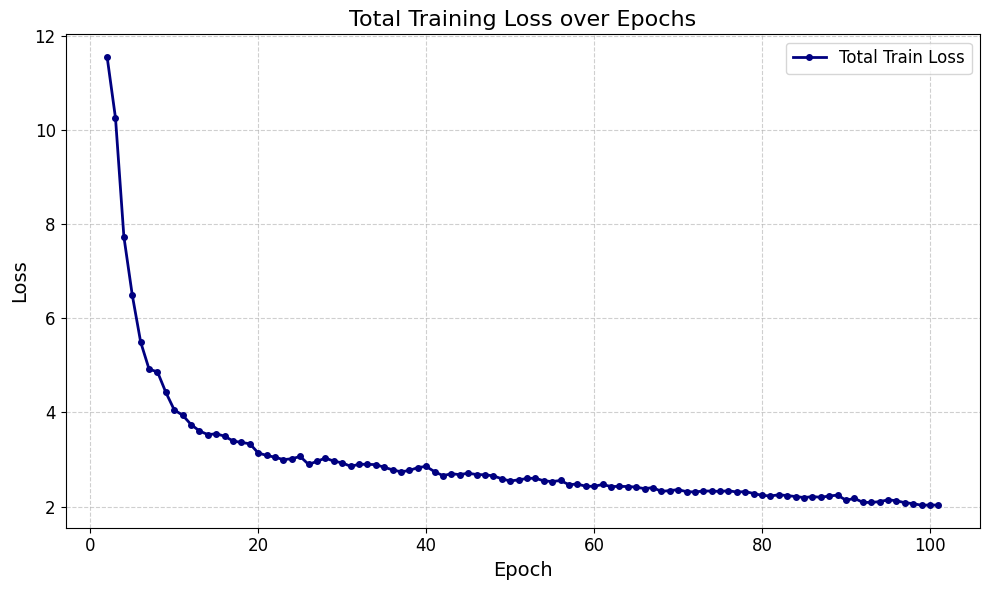

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import os

results_dir = '/content/runs/detect/train'
results_file = os.path.join(results_dir, 'results.csv')

if os.path.exists(results_file):
    df = pd.read_csv(results_file)
    epochs = df['epoch'] + 1

    total_train_loss = df['train/box_loss'] + df['train/cls_loss'] + df['train/dfl_loss']

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, total_train_loss, color='navy', linewidth=2, marker='o', markersize=4, label='Total Train Loss')

    plt.title('Total Training Loss over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

else:
    print(f"results.csv not found at {results_file}")


In [20]:
import pandas as pd
import os

results_dir = '/content/runs/detect/train'
results_file = os.path.join(results_dir, 'results.csv')

if os.path.exists(results_file):
    df = pd.read_csv(results_file)
    print("Available columns in results.csv:")
    print(df.columns)
else:
    print(f"results.csv not found at {results_file}")


Available columns in results.csv:
Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')



image 1/1 /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images/-3_jpg.rf.e879cf17862e63bc5409ad83a369bf23.jpg: 1024x1024 6 bs, 2 bos, 2 ds, 2 das, 25 gos, 2 has, 1 k, 1 ko, 25 ls, 1 la, 1 mi, 120 mos, 61 ngos, 20 nos, 28 ps, 3 sis, 17.8ms
Speed: 9.5ms preprocess, 17.8ms inference, 3.2ms postprocess per image at shape (1, 3, 1024, 1024)


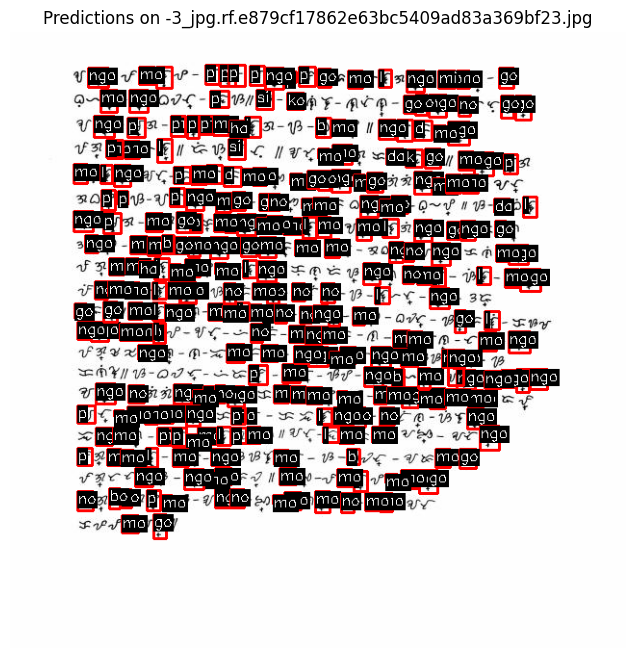


image 1/1 /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images/16_png.rf.0b001c1af3548220526d9c7b19b47372.jpg: 1024x1024 12 bs, 2 das, 1 do, 15 gos, 1 k, 19 ls, 72 mos, 102 ngos, 21 nos, 11 ps, 1 ri, 1 si, 13.4ms
Speed: 6.6ms preprocess, 13.4ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 1024)


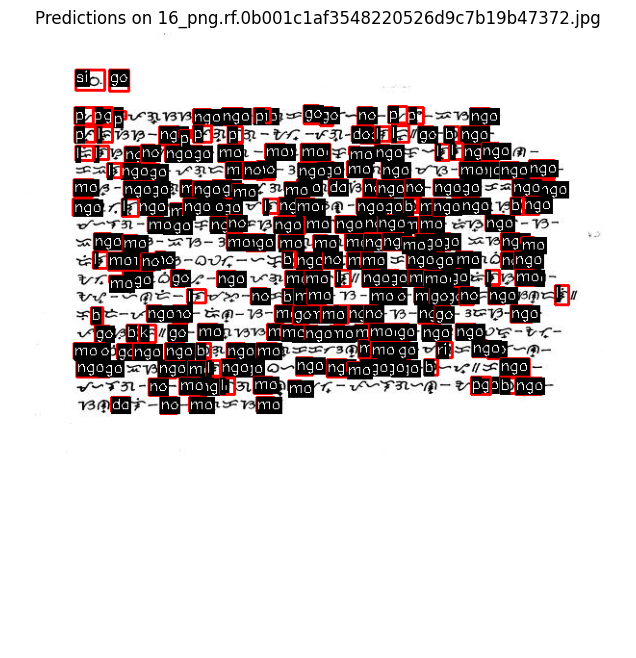


image 1/1 /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images/-8_jpg.rf.22dc3352f639fd264f1db991fd033a61.jpg: 1024x1024 7 bs, 2 ds, 4 das, 35 gos, 1 hi, 3 ks, 1 ko, 22 ls, 143 mos, 42 ngos, 25 nos, 14 ps, 1 si, 13.8ms
Speed: 6.8ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)


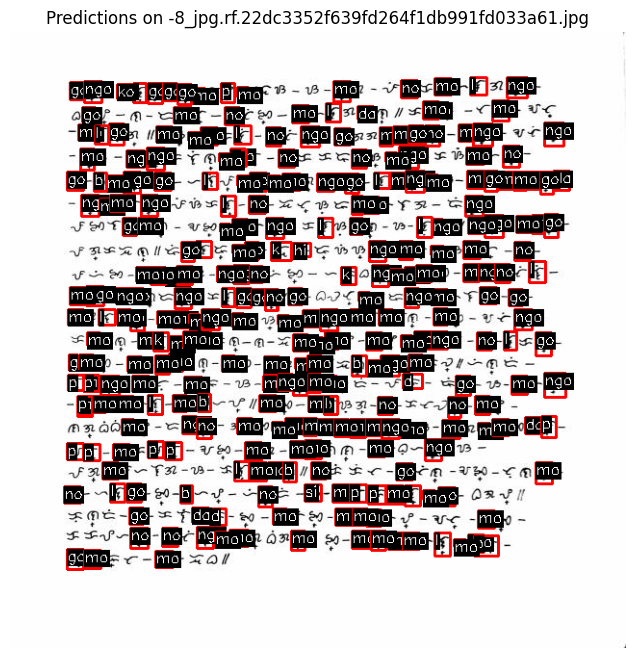


image 1/1 /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images/h_jpeg.rf.b6e7cdd940d5b8904f03ab08e5a11a2a.jpg: 1024x1024 2 as, 1 ba, 2 bos, 1 da, 1 di, 3 gs, 5 gas, 3 has, 1 ho, 2 is, 3 kas, 1 ko, 1 l, 3 las, 1 li, 2 los, 3 ms, 2 mas, 3 mos, 6 ns, 6 nas, 11 ngs, 1 ngi, 3 nis, 1 o, 4 pas, 3 pos, 1 ra, 2 ss, 3 sas, 2 sis, 1 w, 1 wi, 1 ya, 1 yi, 13.3ms
Speed: 7.2ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)


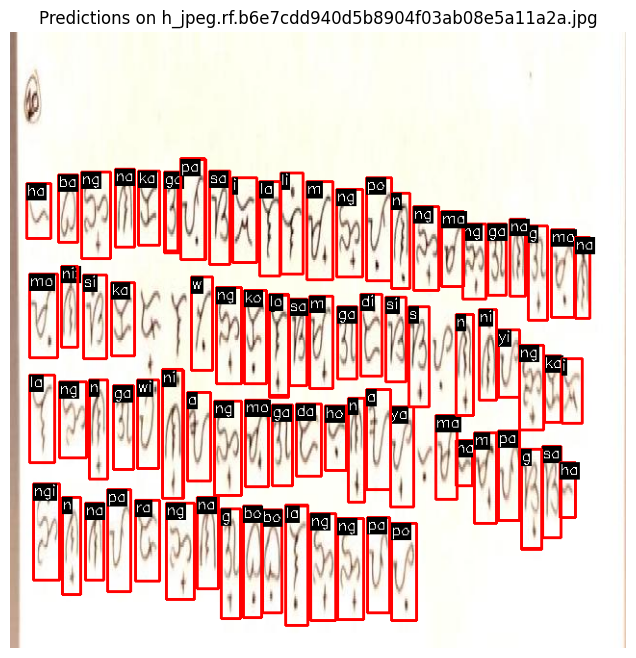


image 1/1 /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images/more6_jpeg.rf.3ebc8f8a1e18d71ff728cb017736dd76.jpg: 1024x1024 2 as, 1 da, 2 las, 13.3ms
Speed: 6.7ms preprocess, 13.3ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)


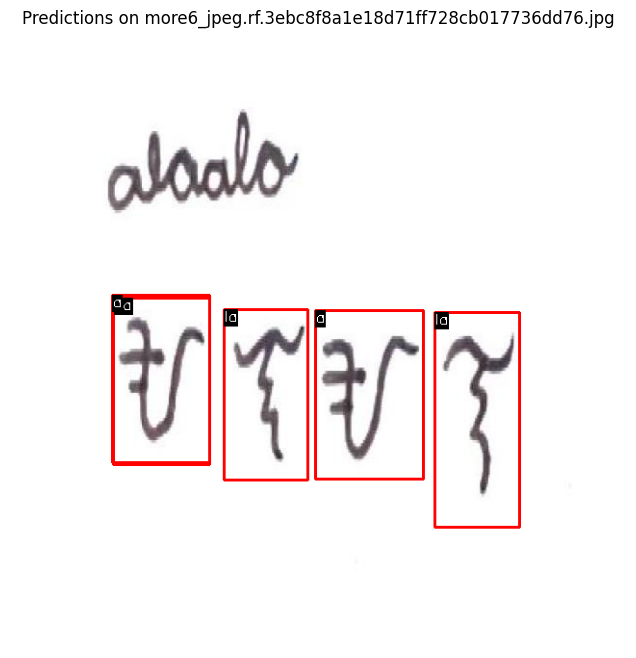


image 1/1 /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images/-7_jpg.rf.0740bcbc8b577259946295d4a8a56fe8.jpg: 1024x1024 8 bs, 3 bos, 3 ds, 4 das, 37 gos, 3 has, 2 ks, 6 ls, 135 mos, 47 ngos, 40 nos, 8 ps, 1 ri, 2 sis, 1 wa, 13.3ms
Speed: 6.6ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 1024)


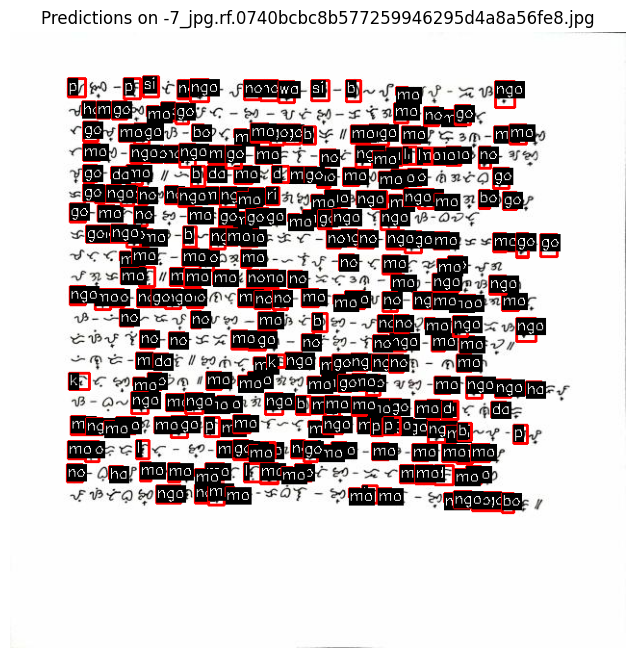


image 1/1 /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images/-2_jpg.rf.4ab53650e4dbd67876922f463ff223c1.jpg: 1024x1024 2 bs, 3 bos, 5 das, 2 dis, 11 gos, 1 ha, 1 hi, 6 ks, 4 kos, 28 ls, 7 mis, 69 mos, 1 n, 45 ngos, 12 nos, 88 ps, 3 ris, 12 sis, 13.3ms
Speed: 6.8ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 1024)


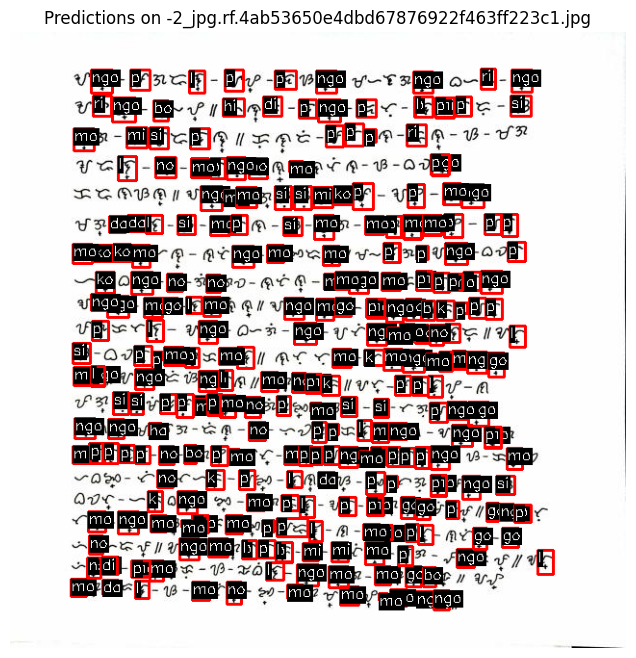


image 1/1 /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images/ag_jpeg.rf.c1e25ba1b83f68eec9085e7a9f131ae7.jpg: 1024x1024 1 bi, 1 bo, 1 ga, 1 la, 1 n, 2 ngs, 2 wis, 13.3ms
Speed: 7.8ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 1024)


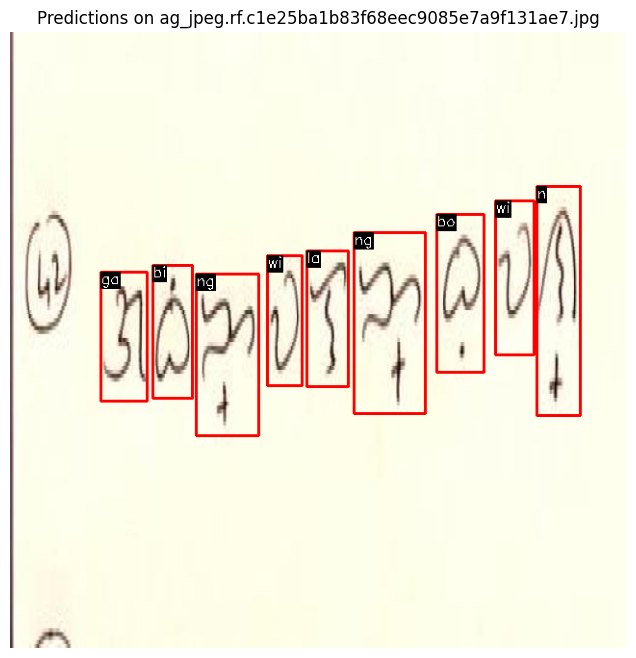


image 1/1 /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images/aq_jpeg.rf.3be9b2e4826e448a8d8d66e9541a32e3.jpg: 1024x1024 1 ga, 1 hi, 1 i, 2 los, 1 n, 1 ti, 13.3ms
Speed: 7.1ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 1024)


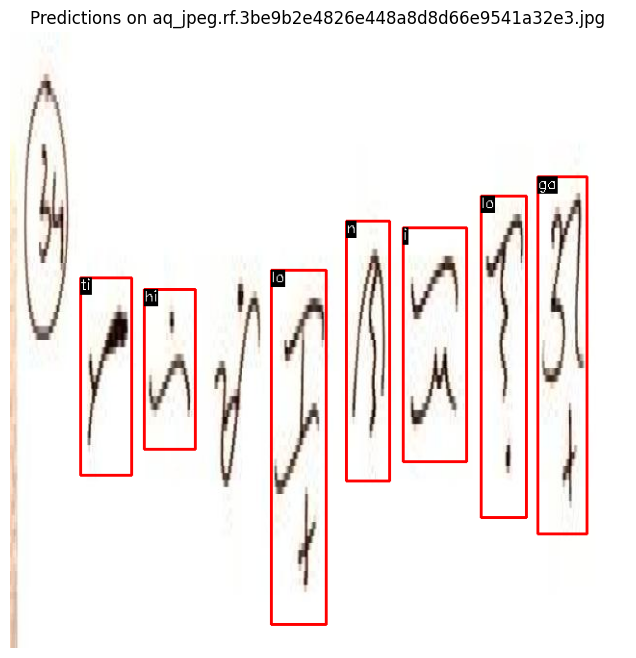


image 1/1 /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images/hey5_jpeg.rf.4cb1dd78fb0ac65bb06e66aadf0ac203.jpg: 1024x1024 5 as, 9 bas, 1 bo, 2 das, 3 dis, 2 gs, 1 ga, 7 has, 2 his, 4 is, 5 ks, 2 kas, 6 kis, 5 kos, 6 ls, 1 la, 2 lis, 1 m, 11 mas, 1 mi, 1 mo, 5 ns, 6 nas, 7 ngs, 3 ngas, 1 no, 1 o, 2 pas, 1 pi, 3 pos, 1 ri, 1 s, 2 sas, 1 si, 7 tas, 7 tis, 2 tos, 2 was, 1 ya, 13.3ms
Speed: 6.6ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)


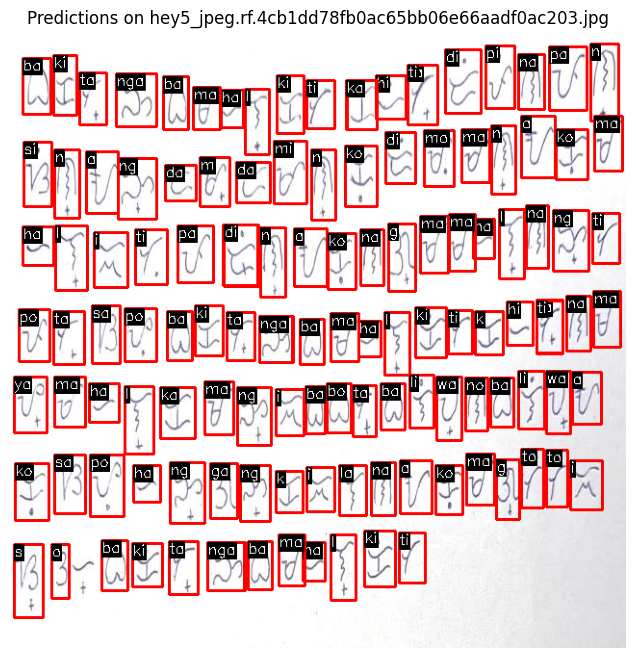

In [48]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import glob

model_path = '/content/runs/detect/train/weights/best.pt'
model = YOLO(model_path)

test_images_dir = '/content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images'
image_paths = glob.glob(os.path.join(test_images_dir, '*.*'))

for img_path in image_paths[:10]:
    results = model.predict(img_path, conf=0.15)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for result in results:
        names = result.names
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_id = int(box.cls[0])
            label = f"{names[cls_id]}"

            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            (text_w, text_h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(img, (x1, y1), (x1 + text_w, y1 + text_h + baseline), (0, 0, 0), -1)
            cv2.putText(img, label, (x1, y1 + text_h),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predictions on {os.path.basename(img_path)}")
    plt.show()


In [46]:
from ultralytics import YOLO
import os
import glob

model_path = '/content/runs/detect/train/weights/best.pt'
model = YOLO(model_path)

test_images_dir = '/content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images'
image_paths = glob.glob(os.path.join(test_images_dir, '*.*'))

for img_path in image_paths[:10]:
    results = model.predict(img_path, conf=0.2)

    detections = []
    for result in results:
        names = result.names
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            cls_id = int(box.cls[0])
            label = f"{names[cls_id]}"
            center_x = (x1 + x2) / 2
            top_y = min(y1, y2)
            detections.append({'label': label, 'x': center_x, 'top_y': top_y})

    line_height_threshold = 60

    detections.sort(key=lambda d: d['top_y'])

    rows = []
    for det in detections:
        placed = False
        for row in rows:
            if abs(row[0]['top_y'] - det['top_y']) < line_height_threshold:
                row.append(det)
                placed = True
                break
        if not placed:
            rows.append([det])

    for row in rows:
        row.sort(key=lambda d: d['x'])

    final_labels = []
    for row in rows:
        final_labels.extend([d['label'] for d in row])

    label_string = ''.join(final_labels)

    print(f"Image {os.path.basename(img_path)} ordered labels (left-to-right, top-to-bottom):")
    print(label_string)



image 1/1 /content/drive/MyDrive/Baybayin.v14i.yolov5pytorch/test/images/-3_jpg.rf.e879cf17862e63bc5409ad83a369bf23.jpg: 1024x1024 6 bs, 2 bos, 2 ds, 2 das, 25 gos, 2 has, 1 k, 1 ko, 25 ls, 1 la, 1 mi, 120 mos, 61 ngos, 20 nos, 28 ps, 3 sis, 13.6ms
Speed: 7.0ms preprocess, 13.6ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)
Image -3_jpg.rf.e879cf17862e63bc5409ad83a369bf23.jpg ordered labels (left-to-right, top-to-bottom):
ngongomopngomolmoppmopppmopphalpsingopkopbgomomolngolgongogodngomomingomonosigogogomolpmongomolpmoppdsimomomogogomongomomogodakngogomomomomomongopngongomopppmomomobpgogomongobmongomomogongogomogomogonomomomomolmomomomongomolngogonongongogongogodamolangolgonogomomomomomohalllngomomongomomomomonomollmomongomononononongonobmongolnomolngonogollmongongongomomomongolmonopmomomongongongomomomongongobmomomomongongongongomongongongolngopngongomomonomomopmomopngomongomomomonogolngomoppmomomomollmongomonomomonomongomomomomongongongopnomobobomomongolpmomong